This notebook implements receding horizon control using the various reduced order models

In [18]:
# Imports
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import numpy as np
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn.utils.extmath import randomized_svd
from prettytable import PrettyTable

import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.animation import FuncAnimation
from dotenv import dotenv_values 
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
import scipy.io
import pyvista as pv
import h5py
import mat73
from scipy import signal
import control
import dask.array as da
import cvxpy as cp
import opinf


config = dotenv_values(".env")
from util import *

# Read in System Matrices

In [19]:
# Setup filepaths for reading data 
filepath = config["currentDirectory"] + "data/archivedDataSets/threeSegmentData200Timesteps/"
# Read in system and gain matrices from .mat file
systemMats = scipy.io.loadmat(filepath + "romSystemMatricesAndGains_12dim_5train_25test.mat")
# ERA matrices
A_era = systemMats["A_era"]
B_era = systemMats["B_era"]
C_era = systemMats["C_era"]
D_era = systemMats["D_era"]
L_era = systemMats["L_era"]
# DMDc Matrices
A_dmdc = systemMats["A_dmdc"]
B_dmdc = systemMats["B_dmdc"]
C_dmdc = systemMats["C_dmdc"]
L_dmdc = systemMats["L_dmdc"]
# Opinf Matrices
A_opInf = systemMats["A_opInf"]
B_opInf = systemMats["B_opInf"]
C_opInf = systemMats["C_opInf"]
L_opInf = systemMats["L_opInf"]
# LOpInf Matrices
A_lopinf = systemMats["A_lopinf"]
B_lopinf = systemMats["B_lopinf"]
C_lopinf = systemMats["C_lopinf"]
D_lopinf = systemMats["D_lopinf"]
L_lopinf = systemMats["L_lopinf"]

# Read in offset vector
x0 = systemMats["x0"]

In [20]:
# Slightly perturbed the lopinf matrices
A_lopinf = A_lopinf #+ 0.000001*np.random.randn(np.shape(A_lopinf)[0],np.shape(A_lopinf)[1])
B_lopinf = B_lopinf #+ 0.0001*np.random.randn(np.shape(B_lopinf)[0],np.shape(B_lopinf)[1])
C_lopinf = C_lopinf #+ 0.0001*np.random.randn(np.shape(C_lopinf)[0],np.shape(C_lopinf)[1])


In [21]:
n = 12 # number of states
m = 6 # number of inputs
p = 40 # number of outputs
T = 500 # prediction horizon
Q = np.eye(n) # state cost matrix
R = np.eye(m) # input cost matrix
P = np.eye(n) # terminal state cost matrix


In [22]:
# Set desired output
beta = 20
y_r  = beta * np.random.randn(p)
dt = 0.001


# Reference Trajectory Generation

In [23]:
# Function to provide coordinates of discretized centerline at a given time
def generateCenterlineCoords(time,numPoints,a_max=0.1,k=10,omega=65):
    # Generate normalized x coordinates
    x = np.linspace(0,1,numPoints)
    # Generate z coordinates
    z = a_max*np.exp(x-1)*np.sin(k*x-omega*time)
    # z = z-z[0]
    x = x-x 
    # interweave x and z coordinates
    y_ref = np.hstack((x.reshape(-1,1),z.reshape(-1,1))).reshape(-1,1).squeeze()
    return y_ref


In [24]:
# Generate matrix of reference coordinates
y_ref = np.zeros((p,T+1))
for i in range(T+1):
    y_ref[:,i] = generateCenterlineCoords(dt*i,p//2,a_max=10)


In [25]:
# Form and solve control problem for each system
# ERA
x_era = cp.Variable((n, T + 1))
u_era = cp.Variable((m, T+1))
du_era = cp.Variable((m, T))
y_era = cp.Variable((p, T + 1))
# DMDc
x_dmdc = cp.Variable((n, T + 1))
u_dmdc = cp.Variable((m, T+1))
du_dmdc = cp.Variable((m, T))
y_dmdc = cp.Variable((p, T + 1))
# lopinf
x_lopinf = cp.Variable((n, T + 1))
u_lopinf = cp.Variable((m, T+1))
du_lopinf = cp.Variable((m, T))
y_lopinf = cp.Variable((p, T + 1))

# Solve the receding horizon control problem using ERA ROM
print("Solving the RHC problem using ERA ROM")
cost_era = 0
constr_era = []
constr_era+= [x_era[:, 0] == np.zeros(n)]
constr_era+= [y_era[:, 0] == C_era @ x_era[:, 0]]
constr_era+= [u_era[:, 0] == np.zeros(m)]
for t in range(T):
    # Only apply cost for odd output indices to penalize the z trajectory error
    cost_era += cp.sum_squares(y_era[1::2,t+1]-y_ref[1::2,t+1])
    # Regularize how far the x trajectory is from the origin
    cost_era += 0.1*cp.sum_squares(y_era[0::2,t+1]-y_ref[0::2,t+1])
    # if t % 2 == 1:
    # cost_era += cp.sum_squares(y_era[:, t + 1]-y_ref[:,t+1])#+ cp.sum_squares(u[:, t])
    cost_era+= cp.sum_squares(du_era[:, t])
    constr_era += [x_era[:, t + 1] == A_era @ x_era[:, t] + B_era @ u_era[:, t+1], cp.norm(u_era[:, t+1], "inf") <= 1]
    constr_era += [y_era[:, t + 1] == C_era @ x_era[:, t + 1] + D_era @ u_era[:, t+1]]
    constr_era += [u_era[:, t+1] == u_era[:, t] + du_era[:, t]]
    # constraints to limit change in input
    # if t > 0:
    #     constr_era += [cp.norm(u_era[:, t] - u_era[:, t - 1],"inf") <= 0.1]
# sums problem objectives and concatenates constraints.
problem_era = cp.Problem(cp.Minimize(cost_era), constr_era)
problem_era.solve(solver='ECOS')

# Solve the receding horizon control problem using DMDc ROM
print("Solving the RHC problem using DMDc ROM")
cost_dmdc = 0
constr_dmdc = []
constr_dmdc+= [x_dmdc[:, 0] == np.zeros(n)]
constr_dmdc+= [y_dmdc[:, 0] == C_dmdc @ x_dmdc[:, 0]]
constr_dmdc+= [u_dmdc[:, 0] == np.zeros(m)]
for t in range(T):
    # Only apply cost for odd time steps to penalize the z trajectory error
    # if t % 2 == 1:
    cost_dmdc += cp.sum_squares(y_dmdc[1::2,t+1]-y_ref[1::2,t+1])#+ cp.sum_squares(u[:, t])
    # Regularize how far the x trajectory is from the origin
    cost_dmdc += 0.1*cp.sum_squares(y_dmdc[0::2,t+1]-y_ref[0::2,t+1])
    cost_dmdc+= cp.sum_squares(du_dmdc[:, t])
    constr_dmdc += [x_dmdc[:, t + 1] == A_dmdc @ x_dmdc[:, t] + B_dmdc @ u_dmdc[:, t+1], cp.norm(u_dmdc[:, t+1], "inf") <= 1]
    constr_dmdc += [y_dmdc[:, t + 1] == C_dmdc @ x_dmdc[:, t + 1]]
    constr_dmdc += [u_dmdc[:, t+1] == u_dmdc[:, t] + du_dmdc[:, t]]
    # constraints to limit change in input
    # if t > 0:
    #     constr_dmdc += [cp.norm(u_dmdc[:, t] - u_dmdc[:, t - 1],"inf") <= 0.1]
# sums problem objectives and concatenates constraints.
problem_dmdc = cp.Problem(cp.Minimize(cost_dmdc), constr_dmdc)
problem_dmdc.solve(solver='ECOS')

# Solve the receding horizon control problem using LOpInf ROM
print("Solving the RHC problem using LOpInf ROM")
cost_lopinf = 0
constr_lopinf = []
constr_lopinf+= [x_lopinf[:, 0] == np.zeros(n)]
constr_lopinf+= [y_lopinf[:, 0] == C_lopinf @ x_lopinf[:, 0]]
constr_lopinf+= [u_lopinf[:, 0] == np.zeros(m)]
for t in range(T):
    # Only apply cost for odd time steps.
    # if t % 2 == 1:
    cost_lopinf += cp.sum_squares(y_lopinf[1::2,t+1]-y_ref[1::2,t+1])#+ cp.sum_squares(u[:, t])
    # Regularize how far the x trajectory is from the origin
    cost_lopinf += 0.1*cp.sum_squares(y_lopinf[0::2,t+1]-y_ref[0::2,t+1])

    cost_lopinf+= cp.sum_squares(du_lopinf[:, t])
    constr_lopinf += [x_lopinf[:, t + 1] == A_lopinf @ x_lopinf[:, t] + B_lopinf @ u_lopinf[:, t+1], cp.norm(u_lopinf[:, t+1], "inf") <= 1]
    constr_lopinf += [y_lopinf[:, t + 1] == C_lopinf @ x_lopinf[:, t + 1] + D_lopinf @ u_lopinf[:, t+1]]
    constr_lopinf += [u_lopinf[:, t+1] == u_lopinf[:, t] + du_lopinf[:, t]]
    # constraints to limit change in input
    # if t > 0:
    #     constr_lopinf += [cp.norm(u_lopinf[:, t] - u_lopinf[:, t - 1],"inf") <= 0.1]
# sums problem objectives and concatenates constraints.
problem_lopinf = cp.Problem(cp.Minimize(cost_lopinf), constr_lopinf)
problem_lopinf.solve(solver='ECOS')

Solving the RHC problem using ERA ROM


Solving the RHC problem using DMDc ROM
Solving the RHC problem using LOpInf ROM


97134.10731039298

# Controllability Study

# RHC Impelementation

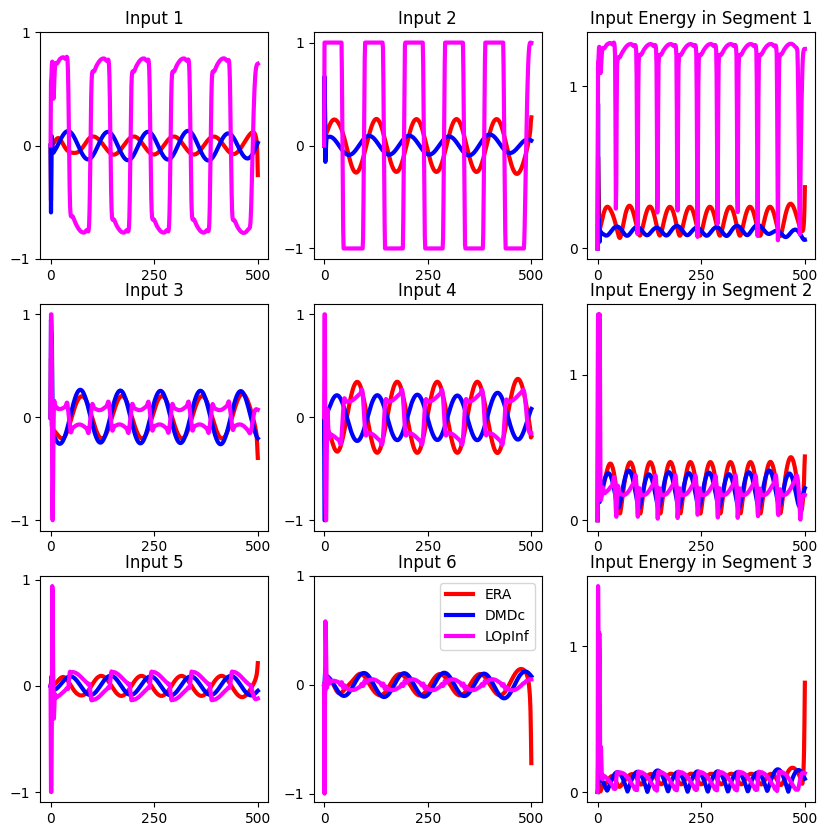

In [26]:
# Plot all 6 inputs for the receding horizon control problem using each of the ROMs with even indexed inputs on the left and odd indexed inputs on the right
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
for i in range(3):
    for j in range(2):
        axs[i, j].plot(u_era[2*i+j,:].value, label='ERA', color='red', linewidth=3)
        axs[i, j].plot(u_dmdc[2*i+j,:].value, label='DMDc', color='blue', linewidth=3)
        axs[i, j].plot(u_lopinf[2*i+j,:].value, label='LOpInf', color='magenta', linewidth=3)
        axs[i, j].set_title('Input ' + str(2*i+j+1))
        # Set ticks 
        axs[i, j].set_xticks([0,250,500])
        axs[i, j].set_yticks([-1,0,1])
                             
    # Plot input energy for each actuation pair
    axs[i, 2].plot(np.sqrt(u_era[2*i,:].value**2+u_era[2*i+1,:].value**2), label='ERA', color='red', linewidth=3)
    axs[i, 2].plot(np.sqrt(u_dmdc[2*i,:].value**2+u_dmdc[2*i+1,:].value**2), label='DMDc', color='blue', linewidth=3)
    axs[i, 2].plot(np.sqrt(u_lopinf[2*i,:].value**2+u_lopinf[2*i+1,:].value**2), label='LOpInf', color='magenta', linewidth=3)
    axs[i, 2].set_title('Input Energy in Segment ' + str(i+1))
    axs[i, 2].set_xticks([0,250,500])
    axs[i, 2].set_yticks([0,1])
axs[i, j].legend()
# save as SVG
plt.savefig('inputs.pdf', format='pdf', dpi=1200)

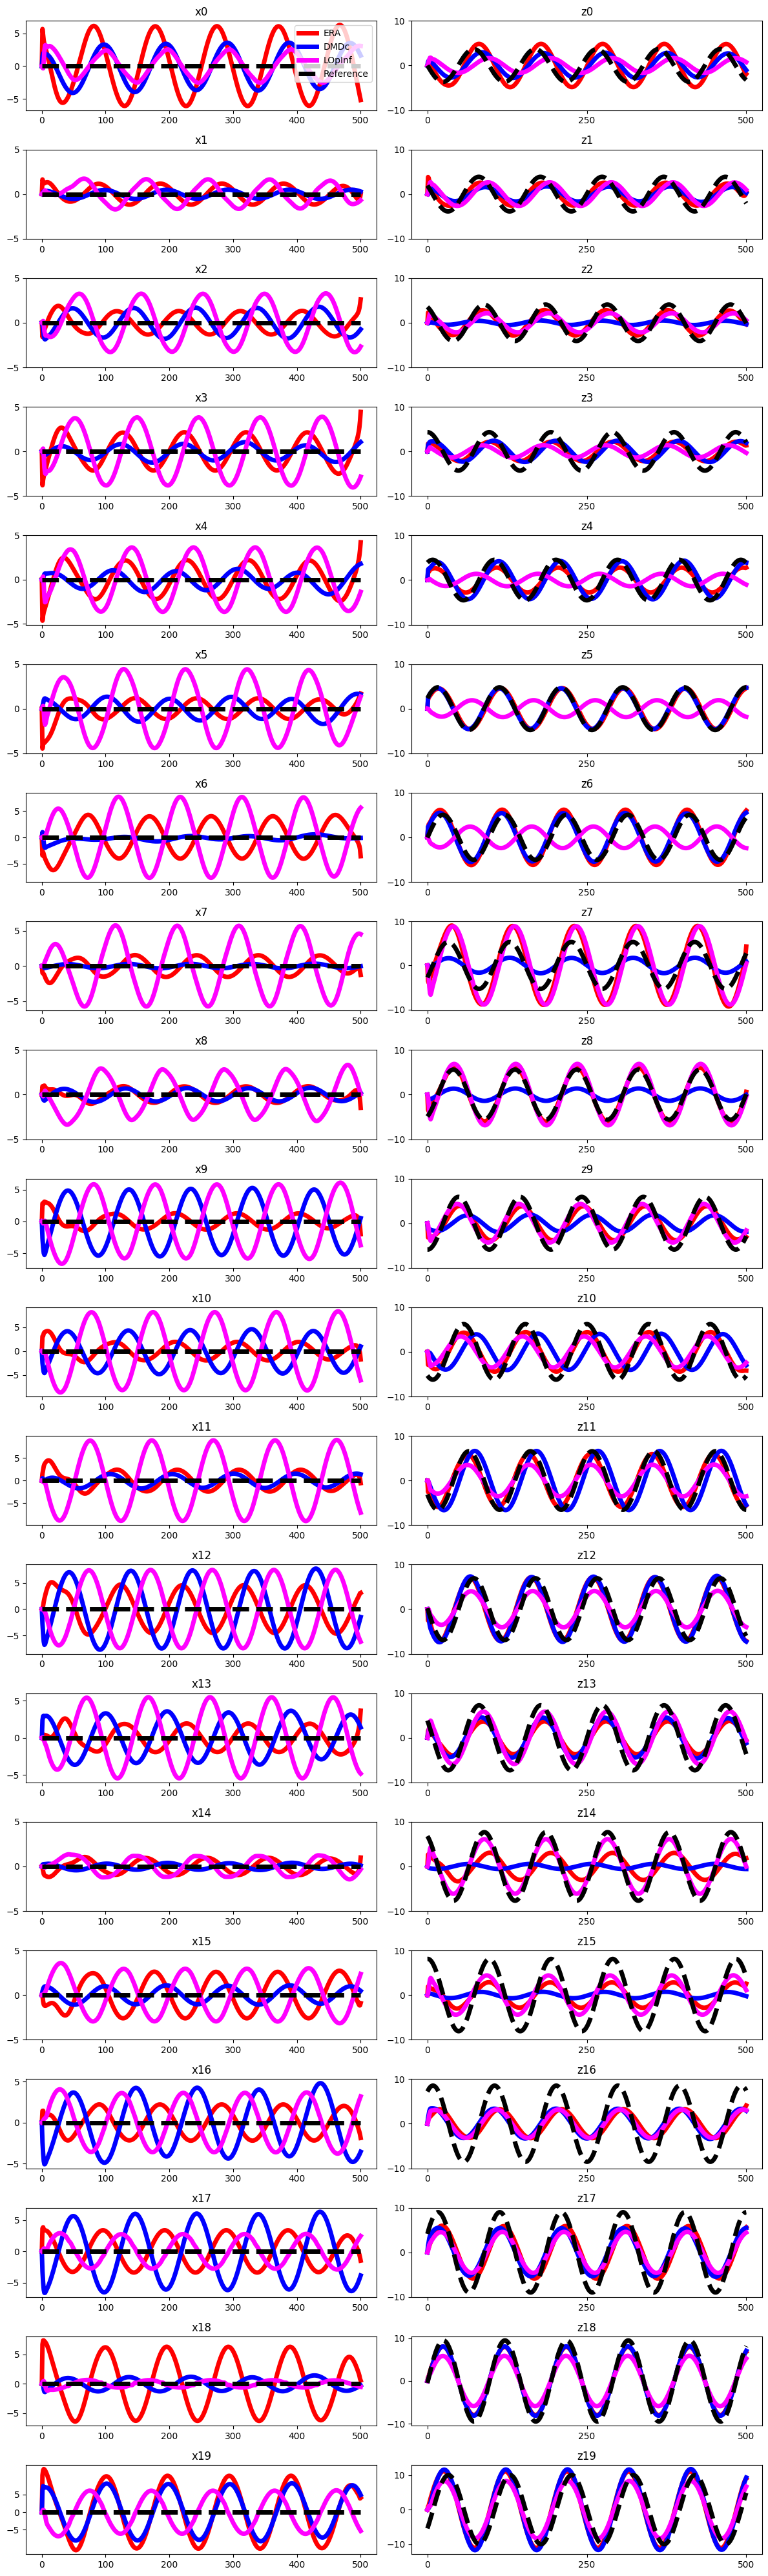

Text(0.5, 0.98, 'Trajectory tracking')

In [27]:
# Plot all 40 outputs of the rom, with xs in one column and zs in the other
fig, axs = plt.subplots(20, 2, figsize=(12, 40))
for i in range(20):
    axs[i, 0].plot(np.arange(T+1), y_era[int(2*i), :].value, label='ERA', color='red',linewidth=5)
    axs[i, 0].plot(np.arange(T+1), y_dmdc[int(2*i), :].value, label='DMDc', color='blue',linewidth=5)
    axs[i, 0].plot(np.arange(T+1), y_lopinf[int(2*i), :].value, label='LOpInf', color='magenta',linewidth=5)
    axs[i, 0].plot(y_ref[int(2*i),:], 'k--', label='Reference',linewidth=5)
    axs[i, 0].set_title('x' + str(i))
    axs[i, 1].set_xticks([0, T/2,T])
    axs[i, 0].set_yticks([-5,0, 5])

    axs[i, 1].plot(np.arange(T+1),y_era[int(2*i+1), :].value, label='ERA', color='red',linewidth=5)
    axs[i, 1].plot(np.arange(T+1),y_dmdc[int(2*i+1), :].value, label='DMDc', color='blue',linewidth=5)
    axs[i, 1].plot(np.arange(T+1),y_lopinf[int(2*i+1), :].value, label='LOpInf', color='magenta',linewidth=5)
    axs[i, 1].plot(y_ref[int(2*i+1),:], 'k--', label='Reference',linewidth=5)
    axs[i, 1].set_title('z' + str(i))
    axs[i, 1].set_xticks([0, T/2,T])
    axs[i, 1].set_yticks([-10,0, 10])


    # add some vertical space between subplots
    # axs[i, 0].set_ylim([-0.5, 0.5])
    # axs[i, 1].set_ylim([-0.5, 0.5])
axs[0, 0].legend()
# axs[i, 1].legend()
plt.tight_layout()
plt.show()
# Add title to figure
fig.suptitle('Trajectory tracking', fontsize=16)
    
    # Plot reference trajectories
    



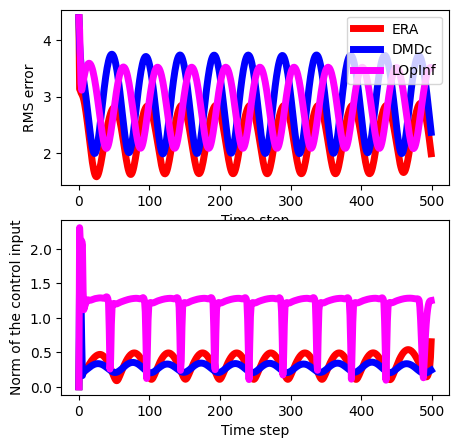

In [28]:
# Plot RMS error and norm of the control input for each rom method
# Initialize vectors to store the RMS error and norm of the control input for each rom method
rms_era = np.zeros(T)
e_input_era = np.zeros(T)
rms_dmdc = np.zeros(T)
e_input_dmdc = np.zeros(T)
rms_lopinf = np.zeros(T)
e_input_lopinf = np.zeros(T)
# Compute the RMS error for each rom method
for i in range(T):
    rms_era[i] = np.sqrt(np.mean((y_era[1::2,i].value - y_ref[1::2,i])**2))
    e_input_era[i] = np.linalg.norm(u_era[:,i].value)
    rms_dmdc[i] = np.sqrt(np.mean((y_dmdc[1::2,i].value - y_ref[1::2,i])**2))
    e_input_dmdc[i] = np.linalg.norm(u_dmdc[:,i].value)
    rms_lopinf[i] = np.sqrt(np.mean((y_lopinf[1::2,i].value - y_ref[1::2,i])**2))
    e_input_lopinf[i] = np.linalg.norm(u_lopinf[:,i].value)

fig, ax = plt.subplots(2, 1, figsize=(5, 5))
ax[0].plot(rms_era, label='ERA', color='red', linewidth=5)
ax[0].plot(rms_dmdc, label='DMDc', color='blue', linewidth=5)
ax[0].plot(rms_lopinf, label='LOpInf', color='magenta', linewidth=5)
ax[0].set_xlabel('Time step')
ax[0].set_ylabel('RMS error')
ax[0].legend()
ax[1].plot(e_input_era, label='ERA', color='red', linewidth=5)
ax[1].plot(e_input_dmdc, label='DMDc', color='blue', linewidth=5)
ax[1].plot(e_input_lopinf, label='LopInf', color='magenta', linewidth=5)
ax[1].set_xlabel('Time step')
ax[1].set_ylabel('Norm of the control input')

#Save as svg file
plt.savefig('RMS_error.pdf', format='pdf', dpi=1200)


# Videos of Results